**Matting**

In [3]:
# Run this cell to install dependencies if missing.
# You can skip if torch, torchvision and kaggle are installed and GPU-ready.

!pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -U kaggle pillow tqdm matplotlib


Looking in indexes: https://download.pytorch.org/whl/cu121
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   -------------------- ------------------- 3.7/7.0 MB 18.8 MB/s eta 0:00:01
   ---------------------------------------- 7.0/7.0 MB 17.9 MB/s  0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   --------------------- ------------------ 4.5/8.1 MB 22.3 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 21.9 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 18.8 MB/s  0:00:00
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 11.7 MB/s  0:00:00
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   -------------- ------------------------- 3.7/9.8 MB 17.1 MB/s eta 0:00:01
   -------------------------- ------------- 6.6/9.8 MB 15.4 MB/s eta 0:00:01
   ------------------------------------ --- 8.9/9.8 MB 14.

In [4]:
import torch
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("🚀 Using GPU:", torch.cuda.get_device_name(0))
    print("CUDA runtime version:", torch.version.cuda)
else:
    DEVICE = torch.device("cpu")
    print("⚠️ GPU not found — using CPU")


⚠️ GPU not found — using CPU


In [12]:
from pathlib import Path
import os

# ---------------- CONFIG - EDIT THESE ----------------
WORKDIR = Path.cwd() / "matting_project"    # main workspace
LOCAL_BG_DATASET_PATH = r'C:\Users\PRABHAKAR\Downloads\1\BG-20k'  # <-- set this to your local dataset root
NUM_BG_TO_COPY = 5000        # how many backgrounds to copy/use (or smaller)
IMG_SIZE = 320
BATCH_SIZE = 8
NUM_EPOCHS = 30
LR = 1e-4
SAVE_DIR = WORKDIR / "checkpoints"
FG_DIR = WORKDIR / "fg"        # put your foreground images here
ALPHA_DIR = WORKDIR / "alpha"  # put your alpha mattes here
BG_OUT_DIR = WORKDIR / "bg"    # backgrounds will be copied here
# ----------------------------------------------------

WORKDIR.mkdir(parents=True, exist_ok=True)
SAVE_DIR.mkdir(parents=True, exist_ok=True)
FG_DIR.mkdir(parents=True, exist_ok=True)
ALPHA_DIR.mkdir(parents=True, exist_ok=True)
BG_OUT_DIR.mkdir(parents=True, exist_ok=True)

print("WORKDIR:", WORKDIR)
print("LOCAL_BG_DATASET_PATH:", LOCAL_BG_DATASET_PATH)
print("FG_DIR:", FG_DIR)
print("ALPHA_DIR:", ALPHA_DIR)
print("BG_OUT_DIR:", BG_OUT_DIR)
print("IMG_SIZE:", IMG_SIZE, "BATCH_SIZE:", BATCH_SIZE)


WORKDIR: c:\Users\PRABHAKAR\Downloads\matting_project
LOCAL_BG_DATASET_PATH: C:\Users\PRABHAKAR\Downloads\1\BG-20k
FG_DIR: c:\Users\PRABHAKAR\Downloads\matting_project\fg
ALPHA_DIR: c:\Users\PRABHAKAR\Downloads\matting_project\alpha
BG_OUT_DIR: c:\Users\PRABHAKAR\Downloads\matting_project\bg
IMG_SIZE: 320 BATCH_SIZE: 8


In [13]:
# This cell will search LOCAL_BG_DATASET_PATH for 'train' first, then 'test', else any folder with images.
from pathlib import Path
import shutil

root = Path(LOCAL_BG_DATASET_PATH)
assert root.exists(), f"LOCAL_BG_DATASET_PATH not found: {root}"

# Candidate target subfolders (prefer 'train', then 'test')
candidates = []
train_dir = root / "train"
test_dir = root / "test"

if train_dir.exists():
    candidates.append(train_dir)
if test_dir.exists():
    candidates.append(test_dir)

# If neither exists, find first folder that contains images (recursively)
if not candidates:
    for p in root.iterdir():
        # check if this entry or its subdirs contain image files
        found = False
        for ext in (".jpg", ".jpeg", ".png"):
            if any(p.rglob(f"*{ext}")):
                found = True
                break
        if found and p.is_dir():
            candidates.append(p)
            break

if not candidates:
    # fallback: search whole tree and pick parent of first image found
    first_img_parent = None
    for p in root.rglob("*"):
        if p.suffix.lower() in [".jpg",".jpeg",".png"]:
            first_img_parent = p.parent
            break
    if first_img_parent:
        candidates.append(first_img_parent)

assert candidates, f"No background images found under {root}. Check your dataset structure."

selected_bg_dir = Path(candidates[0])
print("Selected background source directory:", selected_bg_dir)

# Copy up to NUM_BG_TO_COPY images into BG_OUT_DIR
copied = 0
for img_path in sorted(selected_bg_dir.glob("*")):
    if img_path.suffix.lower() not in [".jpg", ".jpeg", ".png"]:
        continue
    dst = BG_OUT_DIR / img_path.name
    if not dst.exists():
        shutil.copy(img_path, dst)
        copied += 1
    if copied >= NUM_BG_TO_COPY:
        break

print(f"Copied {copied} images to {BG_OUT_DIR}")


Selected background source directory: C:\Users\PRABHAKAR\Downloads\1\BG-20k\train
Copied 1682 images to c:\Users\PRABHAKAR\Downloads\matting_project\bg


In [14]:
import random, math, time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from sklearn.model_selection import train_test_split


c:\Users\PRABHAKAR\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
# ===== REDEFINED Dataset class (use PIL.rotate to avoid torchvision API mismatch) =====
from pathlib import Path
import random
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset

class MattingCompositeDataset(Dataset):
    def __init__(self, fg_list, alpha_list, bg_dir, img_size=320, augment=True):
        self.fg_files = fg_list
        self.alpha_files = alpha_list
        self.bg_files = sorted([p for p in Path(bg_dir).glob("*") if p.suffix.lower() in [".png",".jpg",".jpeg"]])
        assert len(self.fg_files) == len(self.alpha_files), "FG and ALPHA counts must match"
        self.img_size = img_size
        self.augment = augment

    def open_img(self, path, mode="RGB"):
        return Image.open(path).convert(mode)

    def resize_and_center_crop(self, img):
        w, h = img.size
        scale = max(self.img_size / w, self.img_size / h)
        new_w, new_h = int(w * scale), int(h * scale)
        # use BILINEAR for RGB and NEAREST for masks
        resample = Image.BILINEAR if img.mode == "RGB" else Image.NEAREST
        img = img.resize((new_w, new_h), resample=resample)
        left = (new_w - self.img_size)//2
        top = (new_h - self.img_size)//2
        img = img.crop((left, top, left + self.img_size, top + self.img_size))
        return img

    def random_transform(self, fg, alpha, bg):
        # Random horizontal flip
        if random.random() < 0.5:
            fg = fg.transpose(Image.FLIP_LEFT_RIGHT)
            alpha = alpha.transpose(Image.FLIP_LEFT_RIGHT)
            bg = bg.transpose(Image.FLIP_LEFT_RIGHT)
        # Slight random rotation using PIL.Image.rotate (resample arg supported)
        if random.random() < 0.3:
            angle = random.uniform(-10, 10)
            fg = fg.rotate(angle, resample=Image.BILINEAR)
            alpha = alpha.rotate(angle, resample=Image.NEAREST)
            bg = bg.rotate(angle, resample=Image.BILINEAR)
        return fg, alpha, bg

    def to_tensor(self, img):
        arr = np.array(img).astype(np.float32) / 255.0
        if img.mode == "L":
            arr = np.expand_dims(arr, axis=2)
        arr = np.transpose(arr, (2,0,1))
        return torch.from_numpy(arr)

    def __len__(self):
        return len(self.fg_files)

    def __getitem__(self, idx):
        fg = self.open_img(self.fg_files[idx], mode="RGB")
        alpha = self.open_img(self.alpha_files[idx], mode="L")
        bg = self.open_img(random.choice(self.bg_files), mode="RGB")

        fg = self.resize_and_center_crop(fg)
        alpha = self.resize_and_center_crop(alpha)
        bg = self.resize_and_center_crop(bg)

        if self.augment:
            fg, alpha, bg = self.random_transform(fg, alpha, bg)

        fg_t = self.to_tensor(fg)
        alpha_t = self.to_tensor(alpha)
        bg_t = self.to_tensor(bg)
        comp_t = fg_t * alpha_t + bg_t * (1 - alpha_t)

        return {"comp": comp_t.float(), "bg": bg_t.float(), "alpha": alpha_t.float(), "fg": fg_t.float()}


In [39]:
# === RECREATE DATASETS & DATALOADERS (run this now) ===
from torch.utils.data import DataLoader
import os

# If train_fg / train_alpha / val_fg / val_alpha are not in memory, re-run the pairing cell first.
try:
    _ = train_fg, train_alpha, val_fg, val_alpha
except NameError:
    raise RuntimeError("train_fg / train_alpha / val_fg / val_alpha not found. Re-run the pairing cell (robust pairing) first.")

# Create dataset instances using the newly defined MattingCompositeDataset
train_ds = MattingCompositeDataset(train_fg, train_alpha, BG_OUT_DIR, img_size=IMG_SIZE, augment=True)
val_ds   = MattingCompositeDataset(val_fg, val_alpha, BG_OUT_DIR, img_size=IMG_SIZE, augment=False)

# DataLoader workers: Windows -> use 0, otherwise 4
num_workers = 4
if os.name == "nt":
    num_workers = 0

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=max(0, num_workers//2), pin_memory=True)

print("✅ Dataloaders created.")
print(" - Train samples:", len(train_ds))
print(" - Val samples:  ", len(val_ds))
print(" - BG images:    ", len(list(BG_OUT_DIR.glob('*'))))

# show a quick batch to ensure dataloader works
batch = next(iter(train_loader))
print("\nSample batch keys:", list(batch.keys()))
print("Shapes:")
print(" comp:", batch['comp'].shape)
print(" bg:  ", batch['bg'].shape)
print(" alpha:", batch['alpha'].shape)
print(" fg:  ", batch['fg'].shape)


✅ Dataloaders created.
 - Train samples: 900
 - Val samples:   100
 - BG images:     1682

Sample batch keys: ['comp', 'bg', 'alpha', 'fg']
Shapes:
 comp: torch.Size([8, 3, 320, 320])
 bg:   torch.Size([8, 3, 320, 320])
 alpha: torch.Size([8, 1, 320, 320])
 fg:   torch.Size([8, 3, 320, 320])


In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.net(x)

class UNetMatte(nn.Module):
    def __init__(self, in_ch=4, base_ch=32):
        super().__init__()
        self.enc1 = ConvBlock(in_ch, base_ch)
        self.pool = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(base_ch, base_ch*2)
        self.enc3 = ConvBlock(base_ch*2, base_ch*4)
        self.center = ConvBlock(base_ch*4, base_ch*8)
        self.up3 = nn.ConvTranspose2d(base_ch*8, base_ch*4, 2, stride=2)
        self.dec3 = ConvBlock(base_ch*8, base_ch*4)
        self.up2 = nn.ConvTranspose2d(base_ch*4, base_ch*2, 2, stride=2)
        self.dec2 = ConvBlock(base_ch*4, base_ch*2)
        self.up1 = nn.ConvTranspose2d(base_ch*2, base_ch, 2, stride=2)
        self.dec1 = ConvBlock(base_ch*2, base_ch)
        self.out_conv = nn.Conv2d(base_ch, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        c = self.center(self.pool(e3))
        d3 = self.dec3(torch.cat([self.up3(c), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        out = torch.sigmoid(self.out_conv(d1))
        return out
class ResNetUNet(nn.Module):
    def __init__(self, n_channels=4, out_channels=3, pretrained_resnet=None):
        super().__init__()
        if pretrained_resnet is None:
            pretrained_resnet = models.resnet34(pretrained=True)
        # Encoder parts from pretrained resnet34
        # Note: conv1 -> bn1 -> relu produces x0 with 64 channels
        self.inc_conv = nn.Conv2d(n_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # copy pretrained weights for RGB channels, zero-init mask channel if n_channels==4
        w = pretrained_resnet.conv1.weight.data.clone()
        self.inc_conv.weight.data[:, :3, :, :] = w
        if n_channels == 4:
            self.inc_conv.weight.data[:, 3:, :, :].zero_()
        self.inc_bn = pretrained_resnet.bn1
        self.inc_relu = pretrained_resnet.relu
        self.maxpool = pretrained_resnet.maxpool

        self.enc1 = pretrained_resnet.layer1   # 64 channels
        self.enc2 = pretrained_resnet.layer2   # 128 channels
        self.enc3 = pretrained_resnet.layer3   # 256 channels
        self.enc4 = pretrained_resnet.layer4   # 512 channels

        # decoder conv blocks (decoders take concatenated inputs)
        def dec_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            )

        # upsample transpose convs to bring spatial resolution up
        self.up_transpose0 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # e4 -> 256
        self.dec4 = dec_block(256 + 256, 256)   # concat with e3 (256) -> input 512 -> out 256

        self.up_transpose1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # 256 -> 128
        self.dec3 = dec_block(128 + 128, 128)   # concat with e2 (128)

        self.up_transpose2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)   # 128 -> 64
        self.dec2 = dec_block(64 + 64, 64)      # concat with e1 (64)

        self.up_transpose3 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)    # 64 -> 64 (upsample)
        self.dec1 = dec_block(64 + 64, 64)      # concat with x0 (64)

        self.outconv = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        x0 = self.inc_conv(x)       # [B,64,H/2,W/2]
        x0 = self.inc_bn(x0)
        x0 = self.inc_relu(x0)

        x1 = self.maxpool(x0)       # [B,64,H/4,W/4]
        e1 = self.enc1(x1)          # [B,64,H/4,W/4]
        e2 = self.enc2(e1)          # [B,128,H/8,W/8]
        e3 = self.enc3(e2)          # [B,256,H/16,W/16]
        e4 = self.enc4(e3)          # [B,512,H/32,W/32]

        # Decoder: upsample -> concat with corresponding encoder -> conv block
        u4 = self.up_transpose0(e4)           # [B,256,H/16,W/16]
        u4 = torch.cat([u4, e3], dim=1)       # [B,512,H/16,W/16]
        u4 = self.dec4(u4)                    # [B,256,H/16,W/16]

        u3 = self.up_transpose1(u4)           # [B,128,H/8,W/8]
        u3 = torch.cat([u3, e2], dim=1)       # [B,256,H/8,W/8]
        u3 = self.dec3(u3)                    # [B,128,H/8,W/8]

        u2 = self.up_transpose2(u3)           # [B,64,H/4,W/4]
        u2 = torch.cat([u2, e1], dim=1)       # [B,128,H/4,W/4]
        u2 = self.dec2(u2)                    # [B,64,H/4,W/4]

        u1 = self.up_transpose3(u2)           # [B,64,H/2,W/2]
        # Note: x0 has shape [B,64,H/2,W/2], so concat is valid
        u1 = torch.cat([u1, x0], dim=1)       # [B,128,H/2,W/2]
        u1 = self.dec1(u1)                    # [B,64,H/2,W/2]

        out = self.outconv(u1)                # [B,3,H/2,W/2] -> but we need full resolution
        # If needed, upsample to original input size
        out = F.interpolate(out, size=(x.size(2), x.size(3)), mode='bilinear', align_corners=False)
        return out


In [41]:
def alpha_composition_loss(pred_alpha, true_alpha, fg, bg):
    l_alpha = torch.mean(torch.abs(pred_alpha - true_alpha))
    comp_pred = fg * pred_alpha + bg * (1 - pred_alpha)
    comp_true = fg * true_alpha + bg * (1 - true_alpha)
    l_comp = torch.mean(torch.abs(comp_pred - comp_true))
    return l_alpha + l_comp, l_alpha, l_comp


In [42]:
# === Auto-generate coarse alpha masks from images (for debugging/training) ===
# Paste this as one cell and run.

from pathlib import Path
import shutil, os, sys
from PIL import Image, ImageOps
import numpy as np

# ---- EDIT this if your source images are elsewhere ----
SRC_IMG_FOLDER = r"C:\Users\PRABHAKAR\Downloads\1"   # default candidate you found
MAX_SAMPLES = 1000    # how many images to process (reduce if needed)
IMG_OUT_SIZE = None   # optionally resize when saving FG (None = keep original crop in later steps)

# ---- destinations created by notebook config (DO NOT change unless you know what you're doing) ----
FG_OUT = Path("matting_project") / "fg"
ALPHA_OUT = Path("matting_project") / "alpha"
FG_OUT.mkdir(parents=True, exist_ok=True)
ALPHA_OUT.mkdir(parents=True, exist_ok=True)

# ---- ensure opencv available; if not, install it ----
try:
    import cv2
except Exception:
    print("opencv not found — installing opencv-python (this may take a minute)...")
    !pip install -q opencv-python
    import importlib
    importlib.reload(sys.modules.get('cv2', None) or __import__('cv2'))
    import cv2

# ---- gather image files ----
src = Path(SRC_IMG_FOLDER)
if not src.exists():
    raise RuntimeError(f"SRC folder not found: {src}\nChange SRC_IMG_FOLDER to the folder that contains your images.")

imgs = sorted([p for p in src.rglob("*") if p.suffix.lower() in [".png", ".jpg", ".jpeg"]])[:MAX_SAMPLES]
if len(imgs) == 0:
    raise RuntimeError(f"No images found under {src}")

print(f"Found {len(imgs)} images — creating FG + coarse ALPHA (saving to {FG_OUT} and {ALPHA_OUT})")

def make_coarse_alpha(pil_img):
    """Return a uint8 mask (0..255) estimated from a PIL RGB image."""
    # Convert to grayscale array
    gray = np.array(pil_img.convert("L"))
    # Blur to reduce noise
    blur = cv2.GaussianBlur(gray, (7,7), 0)
    # Otsu threshold
    _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Morphological closing then opening to reduce holes/noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    # Heuristic: if mask covers >75% of area then invert (likely background chosen)
    if (mask > 0).mean() > 0.75:
        mask = 255 - mask
    return mask

copied = 0
for p in imgs:
    try:
        img = Image.open(p).convert("RGB")
        # optional resize when saving to project (set IMG_OUT_SIZE to (W,H) if needed)
        if IMG_OUT_SIZE:
            img_save = img.resize(IMG_OUT_SIZE, Image.BILINEAR)
        else:
            img_save = img
        # create mask
        mask_arr = make_coarse_alpha(img)
        # make alpha file name
        fg_name = FG_OUT / p.name
        alpha_name = ALPHA_OUT / (p.stem + "_alpha.png")
        # save
        img_save.save(fg_name)
        Image.fromarray(mask_arr).save(alpha_name)
        copied += 1
    except Exception as e:
        print("skip", p, ":", e)
print(f"Done. Saved {copied} FG images and {copied} ALPHA masks.")

# show a few samples
fg_samples = sorted([x.name for x in FG_OUT.glob("*")])[:10]
alpha_samples = sorted([x.name for x in ALPHA_OUT.glob("*")])[:10]
print("Sample FG files:", fg_samples)
print("Sample ALPHA files:", alpha_samples)

# quick visualize 3 random examples inline (if in notebook)
try:
    import matplotlib.pyplot as plt
    import numpy as np
    from random import sample
    picks = sample(imgs, min(3, len(imgs)))
    fig, axs = plt.subplots(3,3, figsize=(12,12))
    for i,p in enumerate(picks):
        fg_p = FG_OUT / p.name
        alpha_p = ALPHA_OUT / (p.stem + "_alpha.png")
        fg_im = np.array(Image.open(fg_p).convert("RGB"))
        alpha_im = np.array(Image.open(alpha_p).convert("L"))
        axs[i,0].imshow(fg_im); axs[i,0].set_title("FG"); axs[i,0].axis('off')
        axs[i,1].imshow(alpha_im, cmap='gray'); axs[i,1].set_title("Alpha"); axs[i,1].axis('off')
        # composite with a gray background for display
        bg = np.full_like(fg_im, 128)
        alpha_norm = alpha_im[...,None].astype(np.float32)/255.0
        comp = (fg_im.astype(np.float32)*alpha_norm + bg.astype(np.float32)*(1-alpha_norm)).astype(np.uint8)
        axs[i,2].imshow(comp); axs[i,2].set_title("Composite"); axs[i,2].axis('off')
    plt.show()
except Exception:
    pass

print("\nNext: run the Fixed Cell 9 (the pairing + train/val creation cell) to build train/val loaders.")


Found 1000 images — creating FG + coarse ALPHA (saving to matting_project\fg and matting_project\alpha)


KeyboardInterrupt: 

In [ ]:
# ======= Robust Cell 9: Pair FG & ALPHA with multiple heuristics and create dataloaders =======
from pathlib import Path
from sklearn.model_selection import train_test_split
import re
import difflib
from collections import defaultdict

# gather files
fg_files_raw = sorted([p for p in FG_DIR.glob("*") if p.suffix.lower() in [".png", ".jpg", ".jpeg"]])
alpha_files_raw = sorted([p for p in ALPHA_DIR.glob("*") if p.suffix.lower() in [".png", ".jpg", ".jpeg"]])

print("Found FG images:", len(fg_files_raw))
print("Found ALPHA images:", len(alpha_files_raw))

if len(fg_files_raw) == 0:
    raise RuntimeError(f"No foreground images found in FG_DIR: {FG_DIR}")
if len(alpha_files_raw) == 0:
    raise RuntimeError(f"No alpha images found in ALPHA_DIR: {ALPHA_DIR}")

def clean_stem(p):
    s = p.stem.lower()
    s = re.sub(r'[^a-z0-9]', '', s)     # remove non-alphanum
    s = s.replace("alpha", "").replace("mask","").replace("matte","").replace("trimap","")
    return s

# maps
fg_map = {clean_stem(p): p for p in fg_files_raw}
alpha_map = {clean_stem(p): p for p in alpha_files_raw}

paired_fg = []
paired_alpha = []
used_alpha_keys = set()

# Strategy 1: exact cleaned-stem match
for k, pfg in fg_map.items():
    if k in alpha_map:
        paired_fg.append(pfg)
        paired_alpha.append(alpha_map[k])
        used_alpha_keys.add(k)

print("Pairs after exact cleaned-stem matching:", len(paired_fg))

# Strategy 2: if nothing matched and counts equal -> pair by sorted order
if len(paired_fg) == 0 and len(fg_files_raw) == len(alpha_files_raw):
    print("No exact matches — counts equal. Pairing by sorted order (fallback).")
    for f, a in zip(sorted(fg_files_raw), sorted(alpha_files_raw)):
        paired_fg.append(f); paired_alpha.append(a)
    used_alpha_keys = set([clean_stem(a) for a in paired_alpha])

# Strategy 3: numeric ID matching (extract first number sequence from filename)
if len(paired_fg) == 0:
    print("Trying numeric-ID matching...")
    def extract_num(p):
        m = re.search(r'(\d{1,8})', p.stem)
        return m.group(1) if m else None
    num_to_alpha = defaultdict(list)
    for a in alpha_files_raw:
        num = extract_num(a)
        if num:
            num_to_alpha[num].append(a)
    for f in fg_files_raw:
        num = extract_num(f)
        if num and num in num_to_alpha and len(num_to_alpha[num])>0:
            a = num_to_alpha[num].pop(0)
            paired_fg.append(f); paired_alpha.append(a)
            used_alpha_keys.add(clean_stem(a))
    print("Pairs after numeric matching:", len(paired_fg))

# Strategy 4: fuzzy matching (difflib) for remaining unmatched fg
if len(paired_fg) == 0 or len(paired_fg) < len(fg_files_raw):
    print("Applying fuzzy matching for remaining items...")
    # build reverse maps keyed by original stem (not cleaned) for fuzzy compare
    alpha_stems = [a.stem for a in alpha_files_raw]
    alpha_stem_to_p = {a.stem: a for a in alpha_files_raw}
    for f in fg_files_raw:
        if f in paired_fg:
            continue
        # try matching using raw stem and cleaned stem
        candidates = difflib.get_close_matches(f.stem, alpha_stems, n=3, cutoff=0.6)
        if not candidates:
            candidates = difflib.get_close_matches(clean_stem(f), list(alpha_map.keys()), n=3, cutoff=0.6)
        matched = False
        for c in candidates:
            a_path = alpha_stem_to_p.get(c) or alpha_map.get(clean_stem(Path(c)))
            if a_path and clean_stem(a_path) not in used_alpha_keys:
                paired_fg.append(f); paired_alpha.append(a_path)
                used_alpha_keys.add(clean_stem(a_path))
                matched = True
                break
    print("Pairs after fuzzy matching:", len(paired_fg))

# Final: prune duplicates and ensure same length
final_pairs = []
seen_alpha = set()
for f,p in zip(paired_fg, paired_alpha):
    key = p.name
    if key in seen_alpha:
        continue
    final_pairs.append((f,p))
    seen_alpha.add(key)

paired_fg = [x[0] for x in final_pairs]
paired_alpha = [x[1] for x in final_pairs]

print("Total final matched pairs:", len(paired_fg))

# Show examples of matches and unmatched
def sample_list(lst, n=10):
    return [p.name for p in lst[:n]]

print("\nSample matched pairs (first 20):")
for i,(f,a) in enumerate(zip(paired_fg[:20], paired_alpha[:20])):
    print(f"{i+1:2d}. FG: {f.name}   <--->   ALPHA: {a.name}")

unmatched_fg = [p for p in fg_files_raw if p not in paired_fg]
unmatched_alpha = [p for p in alpha_files_raw if p not in paired_alpha]

print(f"\nUnmatched FG count: {len(unmatched_fg)}  (sample: {sample_list(unmatched_fg,10)})")
print(f"Unmatched ALPHA count: {len(unmatched_alpha)}  (sample: {sample_list(unmatched_alpha,10)})")

# If we still have zero pairs -> ask for samples
if len(paired_fg) == 0:
    raise RuntimeError("❌ No FG–ALPHA pairs could be formed with heuristics. Please paste 5 FG filenames and 5 ALPHA filenames (from the samples above) so I can create a custom matching rule.")

# Proceed: train/val split using matched pairs
idxs = list(range(len(paired_fg)))
train_idx, val_idx = train_test_split(idxs, test_size=0.1, random_state=42)

train_fg = [paired_fg[i] for i in train_idx]
train_alpha = [paired_alpha[i] for i in train_idx]
val_fg = [paired_fg[i] for i in val_idx]
val_alpha = [paired_alpha[i] for i in val_idx]

print("\nTrain pairs:", len(train_fg), " Val pairs:", len(val_fg))

# Create datasets & dataloaders
train_ds = MattingCompositeDataset(train_fg, train_alpha, BG_OUT_DIR, img_size=IMG_SIZE, augment=True)
val_ds = MattingCompositeDataset(val_fg, val_alpha, BG_OUT_DIR, img_size=IMG_SIZE, augment=False)

num_workers = 4
import os
if os.name == "nt":
    num_workers = 0

from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=max(0, num_workers//2), pin_memory=True)

print("\n✔ DATA READY:")
print(" - Train samples:", len(train_ds))
print(" - Val samples:", len(val_ds))
print(" - Background images:", len(list(BG_OUT_DIR.glob('*'))))


Found FG images: 1000
Found ALPHA images: 1000
Pairs after exact cleaned-stem matching: 1000
Total final matched pairs: 1000

Sample matched pairs (first 20):
 1. FG: h_0006a281.jpg   <--->   ALPHA: h_0006a281_alpha.png
 2. FG: h_00241c18.jpg   <--->   ALPHA: h_00241c18_alpha.png
 3. FG: h_00577a09.jpg   <--->   ALPHA: h_00577a09_alpha.png
 4. FG: h_00610cbc.jpg   <--->   ALPHA: h_00610cbc_alpha.png
 5. FG: h_00d476bd.jpg   <--->   ALPHA: h_00d476bd_alpha.png
 6. FG: h_0100ce66.jpg   <--->   ALPHA: h_0100ce66_alpha.png
 7. FG: h_010380c8.jpg   <--->   ALPHA: h_010380c8_alpha.png
 8. FG: h_016722ee.jpg   <--->   ALPHA: h_016722ee_alpha.png
 9. FG: h_019af812.jpg   <--->   ALPHA: h_019af812_alpha.png
10. FG: h_01a531f7.jpg   <--->   ALPHA: h_01a531f7_alpha.png
11. FG: h_01d3e6f5.jpg   <--->   ALPHA: h_01d3e6f5_alpha.png
12. FG: h_01d636e5.jpg   <--->   ALPHA: h_01d636e5_alpha.png
13. FG: h_01e42270.jpg   <--->   ALPHA: h_01e42270_alpha.png
14. FG: h_01ed5c4a.jpg   <--->   ALPHA: h_01ed5c

In [43]:
#11
import torch.optim as optim
import time

model = UNetMatte(in_ch=4, base_ch=32).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

print("Model params:", sum(p.numel() for p in model.parameters()))
print("Device:", DEVICE)

Model params: 1928705
Device: cpu


In [45]:
import torch
from collections import defaultdict
from tqdm.auto import tqdm

def prepare_input(batch):
    comp = batch['comp'].to(DEVICE, non_blocking=True)
    bg = batch['bg'].to(DEVICE, non_blocking=True)
    alpha = batch['alpha'].to(DEVICE, non_blocking=True)
    fg = batch['fg'].to(DEVICE, non_blocking=True)

    bg_gray = bg.mean(dim=1, keepdim=True)
    inp = torch.cat([comp, bg_gray], dim=1)  # shape: (B,4,H,W)
    return inp, comp, bg, alpha, fg

def alpha_composition_loss(pred_alpha, true_alpha, fg, bg):
    l_alpha = torch.mean(torch.abs(pred_alpha - true_alpha))

    comp_pred = fg * pred_alpha + bg * (1 - pred_alpha)
    comp_true = fg * true_alpha + bg * (1 - true_alpha)

    l_comp = torch.mean(torch.abs(comp_pred - comp_true))
    return l_alpha + l_comp, l_alpha, l_comp


In [46]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    running = defaultdict(float)
    pbar = tqdm(loader, desc="Train", leave=False)

    for batch in pbar:
        inp, comp, bg, alpha, fg = prepare_input(batch)
        pred_alpha = model(inp)

        loss, l_alpha, l_comp = alpha_composition_loss(pred_alpha, alpha, fg, bg)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running['loss'] += loss.item()
        running['l_alpha'] += l_alpha.item()
        running['l_comp'] += l_comp.item()

        pbar.set_postfix({k: f"{running[k]/(pbar.n+1):.4f}" for k in running})

    for k in running:
        running[k] /= len(loader)

    return running


def validate(model, loader):
    model.eval()
    running = defaultdict(float)

    with torch.no_grad():
        pbar = tqdm(loader, desc="Val", leave=False)
        for batch in pbar:
            inp, comp, bg, alpha, fg = prepare_input(batch)
            pred_alpha = model(inp)

            loss, l_alpha, l_comp = alpha_composition_loss(pred_alpha, alpha, fg, bg)

            running['loss'] += loss.item()
            running['l_alpha'] += l_alpha.item()
            running['l_comp'] += l_comp.item()

            pbar.set_postfix({k: f"{running[k]/(pbar.n+1):.4f}" for k in running})

        for k in running:
            running[k] /= len(loader)

    return running


In [47]:
import matplotlib.pyplot as plt
import numpy as np

def show_sample(batch, pred_alpha=None, idx=0):
    comp = batch['comp'][idx].cpu().numpy().transpose(1,2,0)
    bg = batch['bg'][idx].cpu().numpy().transpose(1,2,0)
    fg = batch['fg'][idx].cpu().numpy().transpose(1,2,0)
    alpha = batch['alpha'][idx].cpu().numpy().transpose(1,2,0)[...,0]

    if pred_alpha is not None:
        pred = pred_alpha[idx].cpu().numpy().transpose(1,2,0)[...,0]
    else:
        pred = None

    cols = 5 if pred is not None else 4
    fig, ax = plt.subplots(1, cols, figsize=(4*cols,4))

    ax[0].imshow(np.clip(comp,0,1)); ax[0].set_title("Composite"); ax[0].axis('off')
    ax[1].imshow(np.clip(bg,0,1)); ax[1].set_title("BG"); ax[1].axis('off')
    ax[2].imshow(np.clip(fg,0,1)); ax[2].set_title("FG"); ax[2].axis('off')
    ax[3].imshow(alpha, cmap='gray'); ax[3].set_title("True Alpha"); ax[3].axis('off')

    if pred is not None:
        ax[4].imshow(pred, cmap='gray'); ax[4].set_title("Pred Alpha"); ax[4].axis('off')

    plt.show()


In [53]:
# ===== FINAL SIMPLE TRAINING LOOP WITH TIME PRINTING =====
import time
import torch
from torch.cuda.amp import autocast, GradScaler

NUM_EPOCHS = 10
scaler = GradScaler()

def compute_iou(pred, target, thr=0.5, eps=1e-7):
    p = (pred >= thr).float()
    t = (target >= thr).float()
    inter = (p * t).sum()
    union = ((p + t) >= 1).float().sum()
    return float((inter + eps) / (union + eps))

history = {"train_loss":[], "val_loss":[], "epoch_time":[], "train_iou":[], "val_iou":[]}

for epoch in range(1, NUM_EPOCHS+1):
    print(f"\n================= EPOCH {epoch}/{NUM_EPOCHS} =================")

    epoch_start = time.time()
    model.train()

    running_loss = 0.0
    running_iou = 0.0
    batches = 0

    for batch in train_loader:
        t0 = time.time()

        inp, comp, bg, alpha, fg = prepare_input(batch)

        with autocast():
            pred = model(inp)
            loss, l_alpha, l_comp = alpha_composition_loss(pred, alpha, fg, bg)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        iou = compute_iou(pred.detach(), alpha.detach())

        running_loss += loss.item()
        running_iou += iou
        batches += 1

        print(f" Batch {batches}: time={time.time()-t0:.3f}s  loss={loss.item():.4f}  iou={iou:.4f}")

    train_loss = running_loss / batches
    train_iou = running_iou / batches

    # -------- Validation --------
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    vb = 0
    with torch.no_grad():
        for batch in val_loader:
            inp, comp, bg, alpha, fg = prepare_input(batch)
            with autocast():
                pred = model(inp)
                loss, l_alpha, l_comp = alpha_composition_loss(pred, alpha, fg, bg)

            iou = compute_iou(pred, alpha)

            val_loss += loss.item()
            val_iou += iou
            vb += 1

    val_loss /= vb
    val_iou /= vb

    epoch_time = time.time() - epoch_start
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_iou"].append(train_iou)
    history["val_iou"].append(val_iou)
    history["epoch_time"].append(epoch_time)

    print(f"\nEpoch {epoch} Completed:")
    print(f"  Time: {epoch_time:.2f} sec")
    print(f"  Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val IoU:   {val_iou:.4f}")


C:\Users\PRABHAKAR\AppData\Local\Temp\ipykernel_10036\1219489951.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



================= EPOCH 1/10 =================


C:\Users\PRABHAKAR\AppData\Local\Temp\ipykernel_10036\1219489951.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


 Batch 1: time=4.610s  loss=0.3539  iou=0.6569
 Batch 2: time=3.995s  loss=0.2786  iou=0.8504
 Batch 3: time=3.852s  loss=0.3054  iou=0.7728
 Batch 4: time=3.549s  loss=0.2737  iou=0.8411
 Batch 5: time=3.616s  loss=0.2806  iou=0.8426
 Batch 6: time=4.489s  loss=0.2924  iou=0.7929
 Batch 7: time=4.274s  loss=0.2686  iou=0.8658
 Batch 8: time=4.918s  loss=0.2959  iou=0.8301
 Batch 9: time=5.113s  loss=0.2987  iou=0.7972
 Batch 10: time=4.816s  loss=0.2664  iou=0.8923
 Batch 11: time=3.623s  loss=0.2773  iou=0.9014
 Batch 12: time=3.553s  loss=0.3056  iou=0.8000
 Batch 13: time=3.560s  loss=0.2958  iou=0.8089
 Batch 14: time=3.594s  loss=0.2803  iou=0.8174
 Batch 15: time=3.571s  loss=0.2957  iou=0.8447
 Batch 16: time=3.517s  loss=0.3191  iou=0.7427
 Batch 17: time=3.534s  loss=0.2973  iou=0.7871
 Batch 18: time=3.529s  loss=0.2595  iou=0.8762
 Batch 19: time=3.503s  loss=0.2528  iou=0.9061
 Batch 20: time=3.563s  loss=0.2784  iou=0.8596
 Batch 21: time=3.586s  loss=0.3193  iou=0.7572
 

C:\Users\PRABHAKAR\AppData\Local\Temp\ipykernel_10036\1219489951.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Epoch 1 Completed:
  Time: 501.14 sec
  Train Loss: 0.2661 | Train IoU: 0.8427
  Val Loss:   0.2249 | Val IoU:   0.8891

================= EPOCH 2/10 =================
 Batch 1: time=4.567s  loss=0.2250  iou=0.8679
 Batch 2: time=4.679s  loss=0.2252  iou=0.8628
 Batch 3: time=4.263s  loss=0.2221  iou=0.8955
 Batch 4: time=4.537s  loss=0.2296  iou=0.8795
 Batch 5: time=4.501s  loss=0.2516  iou=0.8242
 Batch 6: time=4.388s  loss=0.2677  iou=0.7889
 Batch 7: time=4.408s  loss=0.2239  iou=0.8918
 Batch 8: time=4.478s  loss=0.2166  iou=0.9116
 Batch 9: time=4.503s  loss=0.2295  iou=0.8871
 Batch 10: time=4.570s  loss=0.2233  iou=0.9065
 Batch 11: time=4.633s  loss=0.2303  iou=0.8664
 Batch 12: time=4.382s  loss=0.2088  iou=0.9169
 Batch 13: time=4.443s  loss=0.2188  iou=0.9206
 Batch 14: time=4.603s  loss=0.2792  iou=0.7947
 Batch 15: time=4.757s  loss=0.2772  iou=0.8130
 Batch 16: time=4.980s  loss=0.2419  iou=0.8566
 Batch 17: time=5.404s  loss=0.2245  iou=0.8978
 Batch 18: time=4.601s  

Saved training history to c:\Users\PRABHAKAR\Downloads\matting_project\checkpoints\history.json


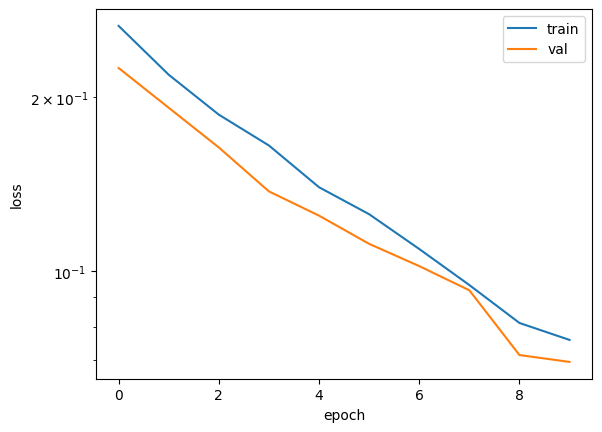

In [54]:
import json

hist_path = SAVE_DIR / "history.json"
with open(hist_path, "w") as f:
    json.dump(history, f)

print("Saved training history to", hist_path)

plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.yscale('log')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.show()

**Inpanting Code**

In [1]:
!pip install --upgrade --quiet datasets

In [1]:
# Imports and device
import os
import io
import random
from datasets import load_dataset
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.utils import save_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)


c:\Users\PRABHAKAR\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


In [2]:
# ===== USER PARAMETERS (EDIT THESE) =====
DATASET_ID = r'C:\Users\PRABHAKAR\Downloads\Inpanting'   # e.g. "username/dataset-name"
IMAGE_KEY  = "image"                        # the dataset field that contains image data
SPLIT_NAMES = {"train":"train", "val":"validation", "test":"test"}  # change keys if needed
IMG_SIZE = 256
BATCH_SIZE = 10
NUM_WORKERS = 4
LR = 1e-4
EPOCHS = 10
OUT_DIR = "./outputs"
os.makedirs(OUT_DIR, exist_ok=True)
# ========================================


In [3]:
# Mask generation (random rectangle masks). Replace with your mask policy if you have ground-truth masks.
def random_mask(img_hw, mask_ratio=0.25, min_size=32, max_rects=4):
    h, w = img_hw
    mask = np.zeros((h, w), dtype=np.uint8)
    area_target = int(h * w * mask_ratio)
    covered = 0
    attempts = 0
    while covered < area_target and attempts < 20:
        rect_h = random.randint(min_size, max(min_size, h//3))
        rect_w = random.randint(min_size, max(min_size, w//3))
        top = random.randint(0, h - rect_h)
        left = random.randint(0, w - rect_w)
        mask[top:top+rect_h, left:left+rect_w] = 1
        covered = mask.sum()
        attempts += 1
    return mask


In [4]:
# Hugging Face Dataset -> PyTorch Dataset wrapper
class HFDatasetWrapper(Dataset):
    def __init__(self, hf_dataset, split, image_key="image", img_size=IMG_SIZE, transform=None):
        self.ds = hf_dataset[split]
        self.image_key = image_key
        self.img_size = img_size
        self.transform = transform or T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.ds)

    def _load_image(self, img_field):
        # handle several common HF image formats: PIL Image, numpy array, bytes, dict with path
        if isinstance(img_field, Image.Image):
            img = img_field.convert("RGB")
        elif isinstance(img_field, bytes):
            img = Image.open(io.BytesIO(img_field)).convert("RGB")
        elif isinstance(img_field, dict):
            # Example: {"path": "..."} or {"bytes": ...}
            if "path" in img_field:
                img = Image.open(img_field["path"]).convert("RGB")
            elif "bytes" in img_field:
                img = Image.open(io.BytesIO(img_field["bytes"])).convert("RGB")
            else:
                # fallback try to convert to array
                img = Image.fromarray(np.asarray(img_field)).convert("RGB")
        else:
            # numpy array or PIL convertible
            img = Image.fromarray(np.asarray(img_field)).convert("RGB")
        return img

    def __getitem__(self, idx):
        item = self.ds[idx]
        if self.image_key not in item:
            raise KeyError(f"Image key '{self.image_key}' not found in dataset item keys: {list(item.keys())[:10]}")
        raw_img = item[self.image_key]
        img = self._load_image(raw_img)
        img_t = self.transform(img)  # [C,H,W], float tensor 0..1

        # mask & masked image
        mask_np = random_mask((self.img_size, self.img_size), mask_ratio=0.25)
        mask = torch.from_numpy(mask_np).unsqueeze(0).float()  # [1,H,W]
        masked_img = img_t * (1 - mask)

        return masked_img, img_t, mask


In [ ]:
# Lightweight UNet for inpainting
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_ch=4, out_ch=3, base=64):
        super().__init__()
        self.enc1 = DoubleConv(in_ch, base)
        self.pool = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(base, base*2)
        self.enc3 = DoubleConv(base*2, base*4)
        self.enc4 = DoubleConv(base*4, base*8)
        self.bottleneck = DoubleConv(base*8, base*16)

        self.up4 = nn.ConvTranspose2d(base*16, base*8, 2, stride=2)
        self.dec4 = DoubleConv(base*16, base*8)
        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.dec3 = DoubleConv(base*8, base*4)
        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec2 = DoubleConv(base*4, base*2)
        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec1 = DoubleConv(base*2, base)

        self.out_conv = nn.Conv2d(base, out_ch, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))

        d4 = self.up4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.out_conv(d1)
        return torch.sigmoid(out)
class ResNetUNet(nn.Module):
    def __init__(self, n_channels=4, out_channels=3, pretrained_resnet=None):
        super().__init__()
        if pretrained_resnet is None:
            pretrained_resnet = models.resnet34(pretrained=True)
        # Encoder parts from pretrained resnet34
        # Note: conv1 -> bn1 -> relu produces x0 with 64 channels
        self.inc_conv = nn.Conv2d(n_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # copy pretrained weights for RGB channels, zero-init mask channel if n_channels==4
        w = pretrained_resnet.conv1.weight.data.clone()
        self.inc_conv.weight.data[:, :3, :, :] = w
        if n_channels == 4:
            self.inc_conv.weight.data[:, 3:, :, :].zero_()
        self.inc_bn = pretrained_resnet.bn1
        self.inc_relu = pretrained_resnet.relu
        self.maxpool = pretrained_resnet.maxpool

        self.enc1 = pretrained_resnet.layer1   # 64 channels
        self.enc2 = pretrained_resnet.layer2   # 128 channels
        self.enc3 = pretrained_resnet.layer3   # 256 channels
        self.enc4 = pretrained_resnet.layer4   # 512 channels

        # decoder conv blocks (decoders take concatenated inputs)
        def dec_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            )

        # upsample transpose convs to bring spatial resolution up
        self.up_transpose0 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # e4 -> 256
        self.dec4 = dec_block(256 + 256, 256)   # concat with e3 (256) -> input 512 -> out 256

        self.up_transpose1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # 256 -> 128
        self.dec3 = dec_block(128 + 128, 128)   # concat with e2 (128)

        self.up_transpose2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)   # 128 -> 64
        self.dec2 = dec_block(64 + 64, 64)      # concat with e1 (64)

        self.up_transpose3 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)    # 64 -> 64 (upsample)
        self.dec1 = dec_block(64 + 64, 64)      # concat with x0 (64)

        self.outconv = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        x0 = self.inc_conv(x)       # [B,64,H/2,W/2]
        x0 = self.inc_bn(x0)
        x0 = self.inc_relu(x0)

        x1 = self.maxpool(x0)       # [B,64,H/4,W/4]
        e1 = self.enc1(x1)          # [B,64,H/4,W/4]
        e2 = self.enc2(e1)          # [B,128,H/8,W/8]
        e3 = self.enc3(e2)          # [B,256,H/16,W/16]
        e4 = self.enc4(e3)          # [B,512,H/32,W/32]

        # Decoder: upsample -> concat with corresponding encoder -> conv block
        u4 = self.up_transpose0(e4)           # [B,256,H/16,W/16]
        u4 = torch.cat([u4, e3], dim=1)       # [B,512,H/16,W/16]
        u4 = self.dec4(u4)                    # [B,256,H/16,W/16]

        u3 = self.up_transpose1(u4)           # [B,128,H/8,W/8]
        u3 = torch.cat([u3, e2], dim=1)       # [B,256,H/8,W/8]
        u3 = self.dec3(u3)                    # [B,128,H/8,W/8]

        u2 = self.up_transpose2(u3)           # [B,64,H/4,W/4]
        u2 = torch.cat([u2, e1], dim=1)       # [B,128,H/4,W/4]
        u2 = self.dec2(u2)                    # [B,64,H/4,W/4]

        u1 = self.up_transpose3(u2)           # [B,64,H/2,W/2]
        # Note: x0 has shape [B,64,H/2,W/2], so concat is valid
        u1 = torch.cat([u1, x0], dim=1)       # [B,128,H/2,W/2]
        u1 = self.dec1(u1)                    # [B,64,H/2,W/2]

        out = self.outconv(u1)                # [B,3,H/2,W/2] -> but we need full resolution
        # If needed, upsample to original input size
        out = F.interpolate(out, size=(x.size(2), x.size(3)), mode='bilinear', align_corners=False)
        return out


In [6]:
# Load HF dataset and create loaders
print("Loading HF dataset:", DATASET_ID)
hf_ds = load_dataset(DATASET_ID)
print("Available splits:", list(hf_ds.keys()))

train_split = SPLIT_NAMES.get("train", "train")
val_split   = SPLIT_NAMES.get("val", "validation")

train_ds = HFDatasetWrapper(hf_ds, split=train_split, image_key=IMAGE_KEY, img_size=IMG_SIZE)
val_ds   = HFDatasetWrapper(hf_ds, split=val_split, image_key=IMAGE_KEY, img_size=IMG_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
print("Train size:", len(train_ds), "Val size:", len(val_ds))


Loading HF dataset: C:\Users\PRABHAKAR\Downloads\Inpanting
Available splits: ['train', 'validation', 'test']
Train size: 71953 Val size: 40504


In [7]:
# Setup model, loss, optimizer
model = UNet(in_ch=4, out_ch=3, base=64).to(device)
criterion = nn.L1Loss()   # pixel L1 on masked region
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [14]:
# ===== HYPERPARAMS (edit if needed) =====
# Set EPOCHS = 5 or 7 here
EPOCHS = 5   # change to 7 if you'd like more epochs

IMG_SIZE = 64        # keep small for fast runs; increase later for better quality
UNET_BASE = 16       # small model
LR = 1e-4

# batch size: larger on GPU, smaller on CPU
import torch
if torch.cuda.is_available():
    BATCH_SIZE = 32
else:
    BATCH_SIZE = 8

NUM_WORKERS = 0
TRAIN_BATCHES_LIMIT = 150   # keep for quick runs; set to None to run full epoch
VAL_BATCHES_LIMIT = 40

OUT_DIR = "./outputs_metrics"
import os
os.makedirs(OUT_DIR, exist_ok=True)

# Recreate datasets/loaders (assumes hf_ds and HFDatasetWrapper are already defined)
train_split = "train"
val_split = "validation"

train_ds = HFDatasetWrapper(hf_ds, split=train_split, image_key=IMAGE_KEY, img_size=IMG_SIZE)
val_ds   = HFDatasetWrapper(hf_ds, split=val_split,   image_key=IMAGE_KEY, img_size=IMG_SIZE)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)

print(f"Running with IMG_SIZE={IMG_SIZE}, UNET_BASE={UNET_BASE}, BATCH_SIZE={BATCH_SIZE}, EPOCHS={EPOCHS}")
print("Train size:", len(train_ds), "Val size:", len(val_ds))


Running with IMG_SIZE=64, UNET_BASE=16, BATCH_SIZE=8, EPOCHS=5
Train size: 71953 Val size: 40504


In [16]:
# ===== TRAINING WITH LIVE ACCURACY PRINTING =====
import torch
from tqdm import tqdm
import numpy as np
import math

# -----------------------------
# accuracy function (masked region)
# -----------------------------
def masked_pixel_accuracy(pred, target, mask, tol=0.05):
    # pred,target: [B,3,H,W], mask: [B,1,H,W]
    pred = pred.detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    mask = mask.detach().cpu().numpy()[:,0]  # [B,H,W]

    B = pred.shape[0]
    accs = []
    for i in range(B):
        m = mask[i]
        if m.sum() == 0:
            accs.append(1.0)
            continue
        p = pred[i]
        t = target[i]
        abs_err = np.mean(np.abs(p - t), axis=0)  # [H,W]
        masked_err = abs_err * m
        correct = (masked_err <= tol).astype(np.float32)
        acc = correct.sum() / (m.sum() + 1e-8)
        accs.append(acc)
    return float(np.mean(accs)) * 100.0

# use mixed precision on GPU
use_amp = torch.cuda.is_available()
if use_amp:
    scaler = torch.cuda.amp.GradScaler()

model.to(device)

for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss = 0.0
    epoch_acc = 0.0
    steps = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=True)

    for i, (masked, target, mask) in enumerate(loop):
        if TRAIN_BATCHES_LIMIT is not None and i >= TRAIN_BATCHES_LIMIT:
            break

        masked = masked.to(device)
        target = target.to(device)
        mask = mask.to(device)

        inp = torch.cat([masked, mask], dim=1)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=use_amp):
            pred = model(inp)
            loss = criterion(pred * mask, target * mask)

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        # compute accuracy for this batch
        batch_acc = masked_pixel_accuracy(pred, target, mask)

        epoch_loss += loss.item()
        epoch_acc += batch_acc
        steps += 1

        # show live metrics in tqdm bar
        loop.set_postfix({
            "loss": f"{epoch_loss/steps:.4f}",
            "acc": f"{epoch_acc/steps:.2f}%"
        })

    # print epoch summary
    print(f"\nEpoch {epoch} Summary:")
    print(f"Train Loss: {epoch_loss/steps:.6f}")
    print(f"Train Accuracy: {epoch_acc/steps:.2f}%\n")

Epoch 1/5:   0%|          | 0/8995 [00:00<?, ?it/s]C:\Users\PRABHAKAR\AppData\Local\Temp\ipykernel_20012\965500912.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
Epoch 1/5:   2%|▏         | 150/8995 [02:38<2:35:21,  1.05s/it, loss=0.0410, acc=311.39%]



Epoch 1 Summary:
Train Loss: 0.041019
Train Accuracy: 311.39%



Epoch 2/5:   2%|▏         | 150/8995 [02:57<2:54:47,  1.19s/it, loss=0.0374, acc=315.39%]



Epoch 2 Summary:
Train Loss: 0.037360
Train Accuracy: 315.39%



Epoch 3/5:   2%|▏         | 150/8995 [02:26<2:24:18,  1.02it/s, loss=0.0364, acc=317.06%]



Epoch 3 Summary:
Train Loss: 0.036409
Train Accuracy: 317.06%



Epoch 4/5:   2%|▏         | 150/8995 [02:22<2:20:11,  1.05it/s, loss=0.0359, acc=317.68%]



Epoch 4 Summary:
Train Loss: 0.035850
Train Accuracy: 317.68%



Epoch 5/5:   2%|▏         | 150/8995 [02:23<2:21:04,  1.04it/s, loss=0.0364, acc=318.18%]


Epoch 5 Summary:
Train Loss: 0.036442
Train Accuracy: 318.18%



In [17]:
# Optional: run inference on test split and save outputs (if test split exists)
if SPLIT_NAMES.get("test", "test") in hf_ds:
    test_split = SPLIT_NAMES.get("test", "test")
    test_ds = HFDatasetWrapper(hf_ds, split=test_split, image_key=IMAGE_KEY, img_size=IMG_SIZE)
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)
    os.makedirs(os.path.join(OUT_DIR, "test_outputs"), exist_ok=True)
    model.eval()
    with torch.no_grad():
        for idx, (masked, target, mask) in enumerate(tqdm(test_loader, desc="Testing")):
            inp = torch.cat([masked.to(device), mask.to(device)], dim=1)
            pred = model(inp)
            composite = masked.to(device) * (1 - mask.to(device)) + pred * mask.to(device)
            save_image(composite.cpu(), os.path.join(OUT_DIR, "test_outputs", f"{idx:05d}.png"))
            # limit to first 500 outputs to avoid huge directories - change as needed
            if idx >= 499:
                break
    print("Test outputs saved to:", os.path.join(OUT_DIR, "test_outputs"))
else:
    print("No test split found in dataset. Skipping test inference.")


Testing:   1%|          | 499/40775 [00:24<33:03, 20.30it/s]

Test outputs saved to: ./outputs_metrics\test_outputs
